In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os 

import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import collections
import copy

import amfe
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator, apply_cyclic_symmetry, get_dofs, rotate_u, set_cyclic_modes_to_component
from amfe.cyclic.cyclic import create_voigt_rotation_matrix, assemble_cyclic_modes
from amfe.linalg.arnoldi import arnoldi_iteration, inverse_arnoldi_iteration, general_inverse_arnoldi_iteration, generalized_arnoldi_iteration
from amfe.linalg.arnoldi import lanczos, is_eigvec, nullspace, LinearSys, power_iteration, ProjLinearSys, compute_modes
from amfe.units import convert




Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using python in global path


In [2]:
mesh_folder = '/home/mlid150/Documents/Demonstrator/Safran Demonstrator/Meshes'
msh_name = r'safran_blisk.inp'
msh_file = os.path.join(mesh_folder,msh_name)
m = amfe.Mesh()
m.import_inp(msh_file,1000)

*************************************************************

Loading Abaqus-mesh from /home/mlid150/Documents/Demonstrator/Safran Demonstrator/Meshes/safran_blisk.inp
Can not read the given string list
WARNING! 3D case were selected
Mesh /home/mlid150/Documents/Demonstrator/Safran Demonstrator/Meshes/safran_blisk.inp successfully imported. 
Assign a material to a physical group.
*************************************************************


In [3]:
from pyfeti import utils
utils.save_object(m,'mesh.pkl')

<IPython.core.display.Javascript object>


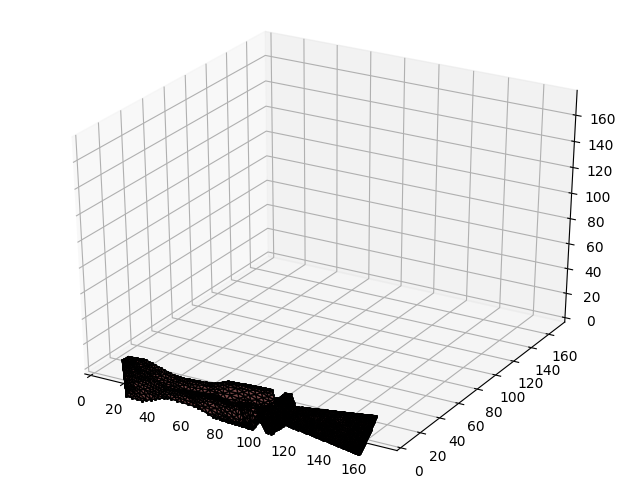

(0, 175)

In [4]:
ax1 = amfe.plot3Dmesh(m)
#pltmesh.show(plot_nodes=False)
vlim=[0,175]
ax1.set_xlim(vlim)
ax1.set_ylim(vlim)
ax1.set_zlim(vlim)
#pltmesh.set_equal_axis_lim(vlim)

In [5]:
print(m.get_elem_types())
print(m.get_phys_group_types())

{'Tet4', 'Tri3'}
{'N_INTERFACE_ELSET', 'BLADE_2_1_ELSET', 'BLADE_2_4_ELSET', 'DISK_1_5_SOLID_ELSET', 'BLADE_2_3_SOLID_ELSET', 'DISK_1_4_ELSET', 'DISK_1_2_ELSET', 'BLADE_2_6_ELSET', 'BLADE_2_3_ELSET', 'BLADE_2_4_SOLID_ELSET', 'BLADE_2_5_ELSET', 'CTC_ALL_ELSET', 'DISK_1_6_ELSET', 'BLADE_2_7_SOLID_ELSET', 'DISK_1_3_ELSET', 'DISK_1_2_SOLID_ELSET', 'BLADE_2_2_SOLID_ELSET', 'E_PROFIL_ELSET', 'DISK_1_1_ELSET', 'DISK_1_6_SOLID_ELSET', 'DISK_1_1_SOLID_ELSET', 'BLADE_2_6_SOLID_ELSET', 'N_CYCLIC_DISQUE_ELSET', 'TGT_ALL_ELSET', 'BLADE_2_2_ELSET', 'DISK_1_5_ELSET', 'BLADE_2_7_ELSET', 'BLADE_2_1_SOLID_ELSET', 'DISK_1_3_SOLID_ELSET', 'DISK_1_4_SOLID_ELSET'}


In [6]:
map_string = lambda  i : 'DISK_1_%i_SOLID_ELSET' %i

# rename solid components

for i in range(1,7):
    m.change_tag_in_eldf('phys_group',map_string(i),'DISK')


In [7]:
print(m.get_phys_group_types())

{'N_INTERFACE_ELSET', 'BLADE_2_1_ELSET', 'BLADE_2_4_ELSET', 'BLADE_2_3_SOLID_ELSET', 'DISK_1_4_ELSET', 'DISK_1_2_ELSET', 'DISK', 'BLADE_2_6_ELSET', 'BLADE_2_3_ELSET', 'BLADE_2_4_SOLID_ELSET', 'BLADE_2_5_ELSET', 'CTC_ALL_ELSET', 'DISK_1_6_ELSET', 'BLADE_2_7_SOLID_ELSET', 'DISK_1_3_ELSET', 'BLADE_2_2_SOLID_ELSET', 'TGT_ALL_ELSET', 'E_PROFIL_ELSET', 'N_CYCLIC_DISQUE_ELSET', 'DISK_1_1_ELSET', 'BLADE_2_6_SOLID_ELSET', 'BLADE_2_2_ELSET', 'DISK_1_5_ELSET', 'BLADE_2_7_ELSET', 'BLADE_2_1_SOLID_ELSET'}


In [8]:
m.split_in_groups()  
disk = m.get_submesh('phys_group','DISK')

<IPython.core.display.Javascript object>


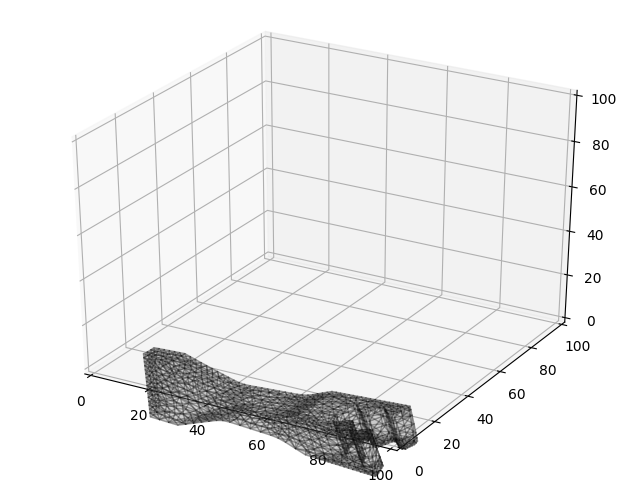

(0, 100)

In [9]:
ax2 = amfe.plot3D_submesh(disk,plot_nodes=False)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)
ax2.set_zlim(0,100)

In [10]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
rho = 7.85E-9 # kg/mm3
E = 2.10E5 # MPa = N/mm2
my_material = amfe.KirchhoffMaterial(E=E, nu=0.3, rho=rho, plane_stress=False)
my_comp.set_domain('DISK',my_material)
print('Number of nodes is equal to %i' %my_comp.mesh_class.no_of_nodes)


Preallocating the stiffness matrix
Done preallocating stiffness matrix with 11880 elements and 8280 dofs.
Time taken for preallocation: 0.56 seconds.
Number of nodes is equal to 2760


In [11]:
K, f = my_comp.assembly_class.assemble_k_and_f()

In [12]:
M = my_comp.assembly_class.assemble_m()

In [13]:
from scipy import sparse

lu = sparse.linalg.splu(K.tocsc())
D = sparse.linalg.LinearOperator(shape=K.shape,matvec=lambda x :lu.solve(M.dot(x)))

eigval, eigvec = sparse.linalg.eigs(D,k=20)

In [14]:
omega = 1.0/np.sqrt(eigval.real)
print(omega)

f = omega/(2.0*np.pi)

[           nan 8.84230897e-03            nan 1.40463564e-02
 1.40463564e-02 1.92160249e-02 4.81109895e+04 6.40661123e+04
 6.84896365e+04 9.66732764e+04 1.30512379e+05 1.51776633e+05
 1.56217197e+05 1.75389140e+05 1.91174822e+05 1.98854091e+05
 2.31646806e+05 2.76180429e+05 2.89889350e+05 3.00025032e+05]


/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [15]:
eigval

array([-1.35267893e+04  +0.j        ,  1.27899435e+04  +0.j        ,
       -3.98294469e+03  +0.j        ,  5.06842043e+03+417.32572104j,
        5.06842043e+03-417.32572104j,  2.70815112e+03  +0.j        ,
        4.32027530e-10  +0.j        ,  2.43637008e-10  +0.j        ,
        2.13181875e-10  +0.j        ,  1.07000825e-10  +0.j        ,
        5.87079059e-11  +0.j        ,  4.34100384e-11  +0.j        ,
        4.09772037e-11  +0.j        ,  3.25083257e-11  +0.j        ,
        2.73614187e-11  +0.j        ,  2.52889582e-11  +0.j        ,
        1.86357711e-11  +0.j        ,  1.31103474e-11  +0.j        ,
        1.18996853e-11  +0.j        ,  1.11092571e-11  +0.j        ])

In [16]:
print(f)

[           nan 1.40729718e-03            nan 2.23554705e-03
 2.23554705e-03 3.05832534e-03 7.65710179e+03 1.01964385e+04
 1.09004642e+04 1.53860298e+04 2.07716902e+04 2.41560014e+04
 2.48627391e+04 2.79140486e+04 3.04264179e+04 3.16486116e+04
 3.68677342e+04 4.39554805e+04 4.61373231e+04 4.77504669e+04]
